In [1]:
!nvidia-smi

Mon May  9 16:11:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K40c          Off  | 00000000:02:00.0 Off |                    0 |
| 23%   45C    P0    61W / 235W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K40c          Off  | 00000000:03:00.0 Off |                    0 |
| 24%   

In [2]:
gpus = [1]
import os
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [1]:
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *
from itertools import product

tf.compat.v1.disable_eager_execution()

# Load data

sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *
from helpers.plot_functions import *

dataset = Dataset('Starling')
analysis = 'stable_length'

species_folder = dataset.path_save
analysis_folder = os.path.join(species_folder, analysis)
log_folder = os.path.join(analysis_folder, 'log')
behavior_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/morph')

In [3]:
results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/exclude_one_training')

In [4]:
subjs = sorted(list(set([path.split('/')[-1].split('_')[0] for path in glob(os.path.join(results_folder, '*'))])))

In [5]:
def check_reverse(subj, morph_dim):
    if subj in ['B1088', 'B1105']:
        if morph_dim in [a+b for a, b in list(product('efcd', 'gh'))]:
            return True
        else:
            return False
    elif subj in ['B1101', 'B1222']:
        if morph_dim in [a+b for a, b in list(product('cd', 'ef'))]:
            return True
        else:
            return False
    else:
        return False

In [6]:
all_values = []
all_conditions = []
all_subjs = []
all_morphs = []
all_ids = []
for subj in subjs:
    subj_folders = glob(os.path.join(results_folder, f'{subj}*'))
    for folder in subj_folders:
        results_file = os.path.join(folder, 'test_results.p')
        if not os.path.exists(results_file):
            continue
        predictions, targets = pickle.load(open(results_file, 'rb'))
        morph = folder.split('/')[-1].split('_')[-1]
        if check_reverse(subj, morph):
            predictions = [1-predict for predict in predictions]
            targets = [1-target for target in targets]
        all_values+=list(predictions)
        all_ids+=list(np.arange(1,129,1))
        all_morphs+= ([morph]*128)
        all_subjs+= ([subj]*128)
        all_conditions+=(['prediction']*128)
        
        all_values+=list(targets)
        all_ids+=list(np.arange(1,129,1))
        all_morphs+= ([morph]*128)
        all_subjs+= ([subj]*128)
        all_conditions+=(['target']*128)

In [7]:
all_df = pd.DataFrame({'subj': all_subjs, 
                       'id': all_ids, 
                       'morph_dim': all_morphs, 
                       'value': all_values,
                       'condition': all_conditions})

In [8]:
all_df['lesser_dim'] = all_df.morph_dim.apply(lambda x: x[0])
all_df['greater_dim'] = all_df.morph_dim.apply(lambda x: x[1])

In [9]:
all_df.tail()

,subj,id,morph_dim,value,condition,lesser_dim,greater_dim
32763,B979,124,bf,0.999,target,b,f
32764,B979,125,bf,0.999,target,b,f
32765,B979,126,bf,0.999,target,b,f
32766,B979,127,bf,0.999,target,b,f
32767,B979,128,bf,0.999,target,b,f


In [10]:
cohort_subj_dic = {"B979": 'Cohort 3', 
                   "B1107": 'Cohort 3', 
                   "B1082": 'Cohort 3', 
                   "B1218": 'Cohort 3', 
                   "B1088": 'Cohort 1',  
                   "B1105": 'Cohort 1', 
                   "B1222": 'Cohort 2',  
                   "B1101": 'Cohort 2'}
cohort_palette = {'Cohort 1':'b', 'Cohort 2': 'g', 'Cohort 3': 'y'}
subj_palette = {"B979": 'gold', 
               "B1107": 'orange', 
               "B1082": 'darkorange', 
               "B1218": 'khaki', 
               "B1088": 'steelblue',  
               "B1105": 'deepskyblue', 
               "B1222": 'darkolivegreen',  
               "B1101": 'darkseagreen'}

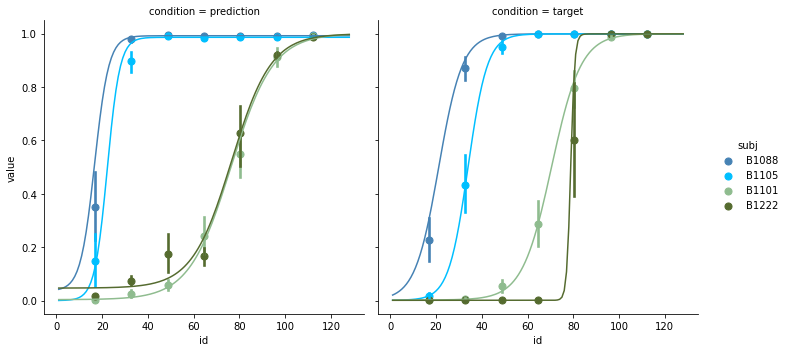

In [116]:
g = sns.lmplot(x='id', y='value', data = all_df, hue='subj', col = 'condition',
               fit_reg=False, x_bins=7, palette=subj_palette)
g.map_dataframe(fourpl, 'id', 'value')

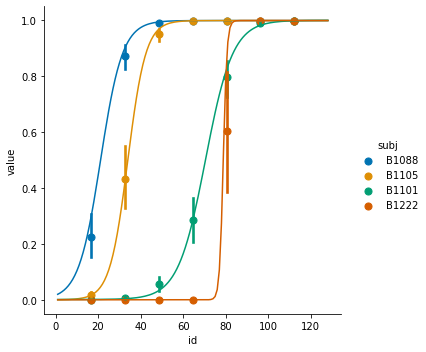

In [115]:
g = sns.lmplot(x='id', y='value', data = all_df[all_df.condition=='target'], hue='subj', fit_reg=False, x_bins=7)
g.map_dataframe(fourpl, 'id', 'value')

../star_scale/math_utils.py:397: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
../star_scale/math_utils.py:533: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
../star_scale/math_utils.py:536: RuntimeWarning: overflow encountered in exp
  temp1 = np.exp(-B * (x - M))
../star_scale/math_utils.py:539: RuntimeWarning: overflow encountered in square
  temp2 = temp1 / (1.0 + temp1) ** 2
../star_scale/math_utils.py:539: RuntimeWarning: invalid value encountered in true_divide
  temp2 = temp1 / (1.0 + temp1) ** 2
../star_scale/math_utils.py:539: RuntimeWarning: overflow encountered in square
  temp2 = temp1 / (1.0 + temp1) ** 2


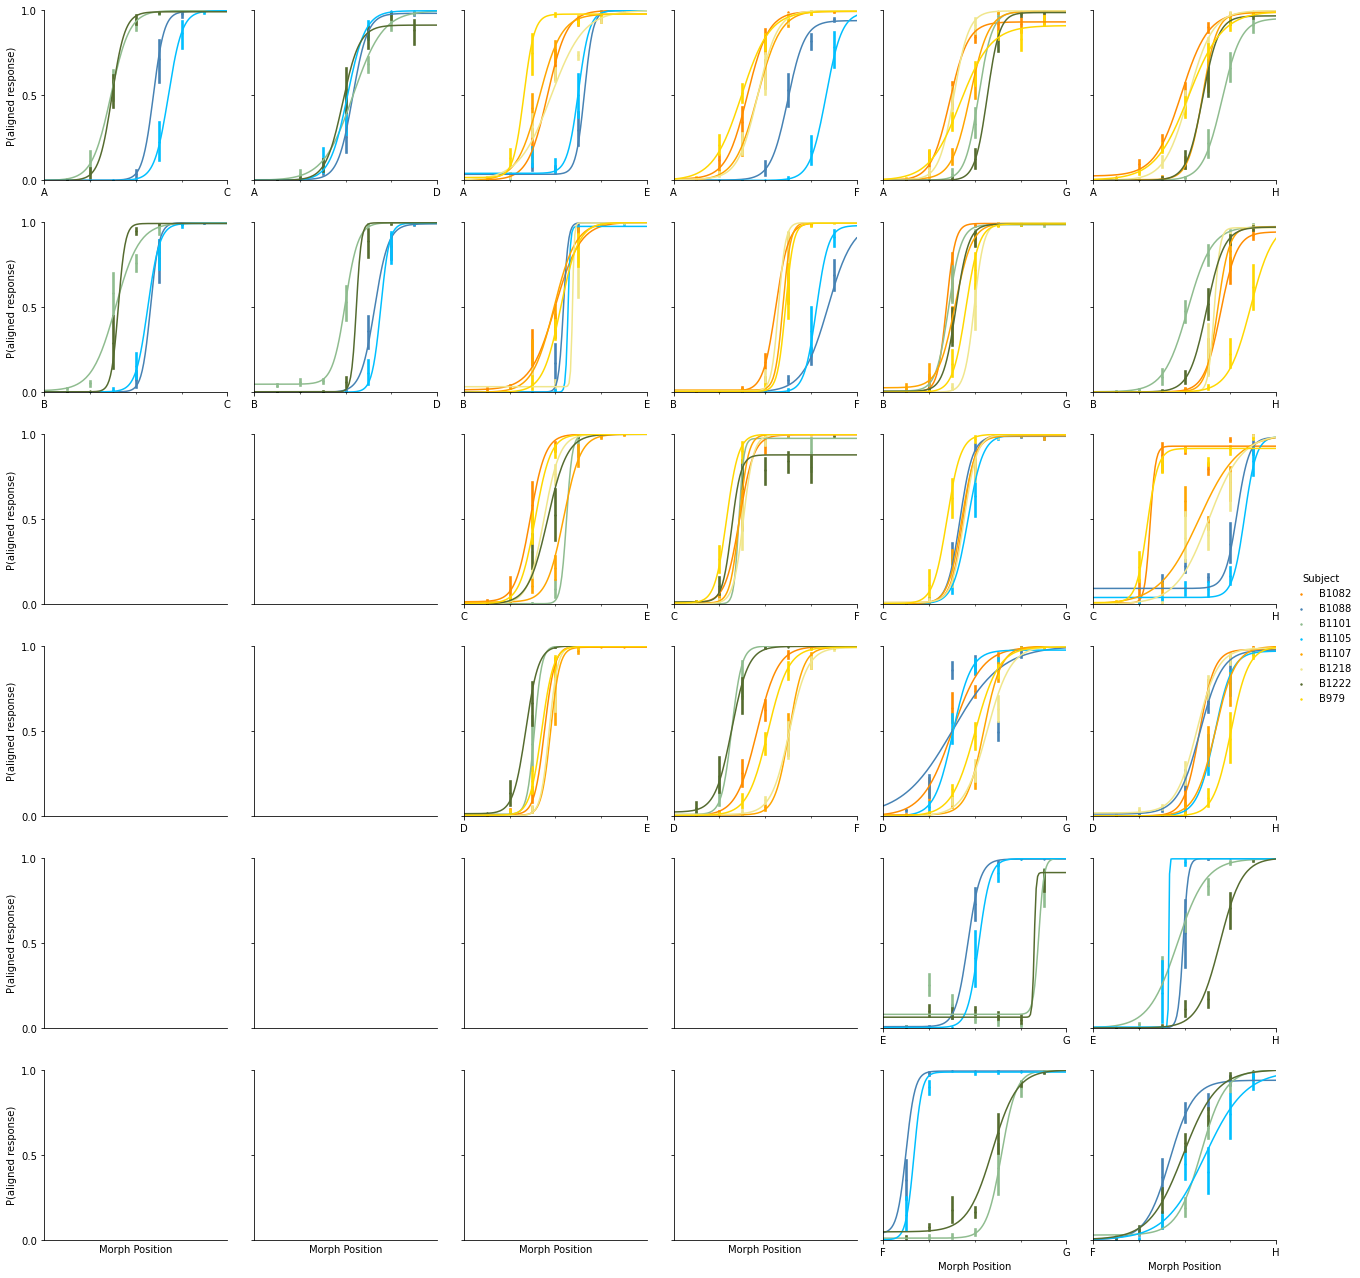

In [19]:
plot_psychometric(all_df[all_df.condition=='prediction'],
                  x='id',
                  y='value',
                  hue='subj',
                  scatter_kws={"s": 2},
                  x_bins=7,
                  col_order="cdefgh",
                  row_order="abcdef",
                  fit_reg='4pl',
                  custom_palette=subj_palette,)

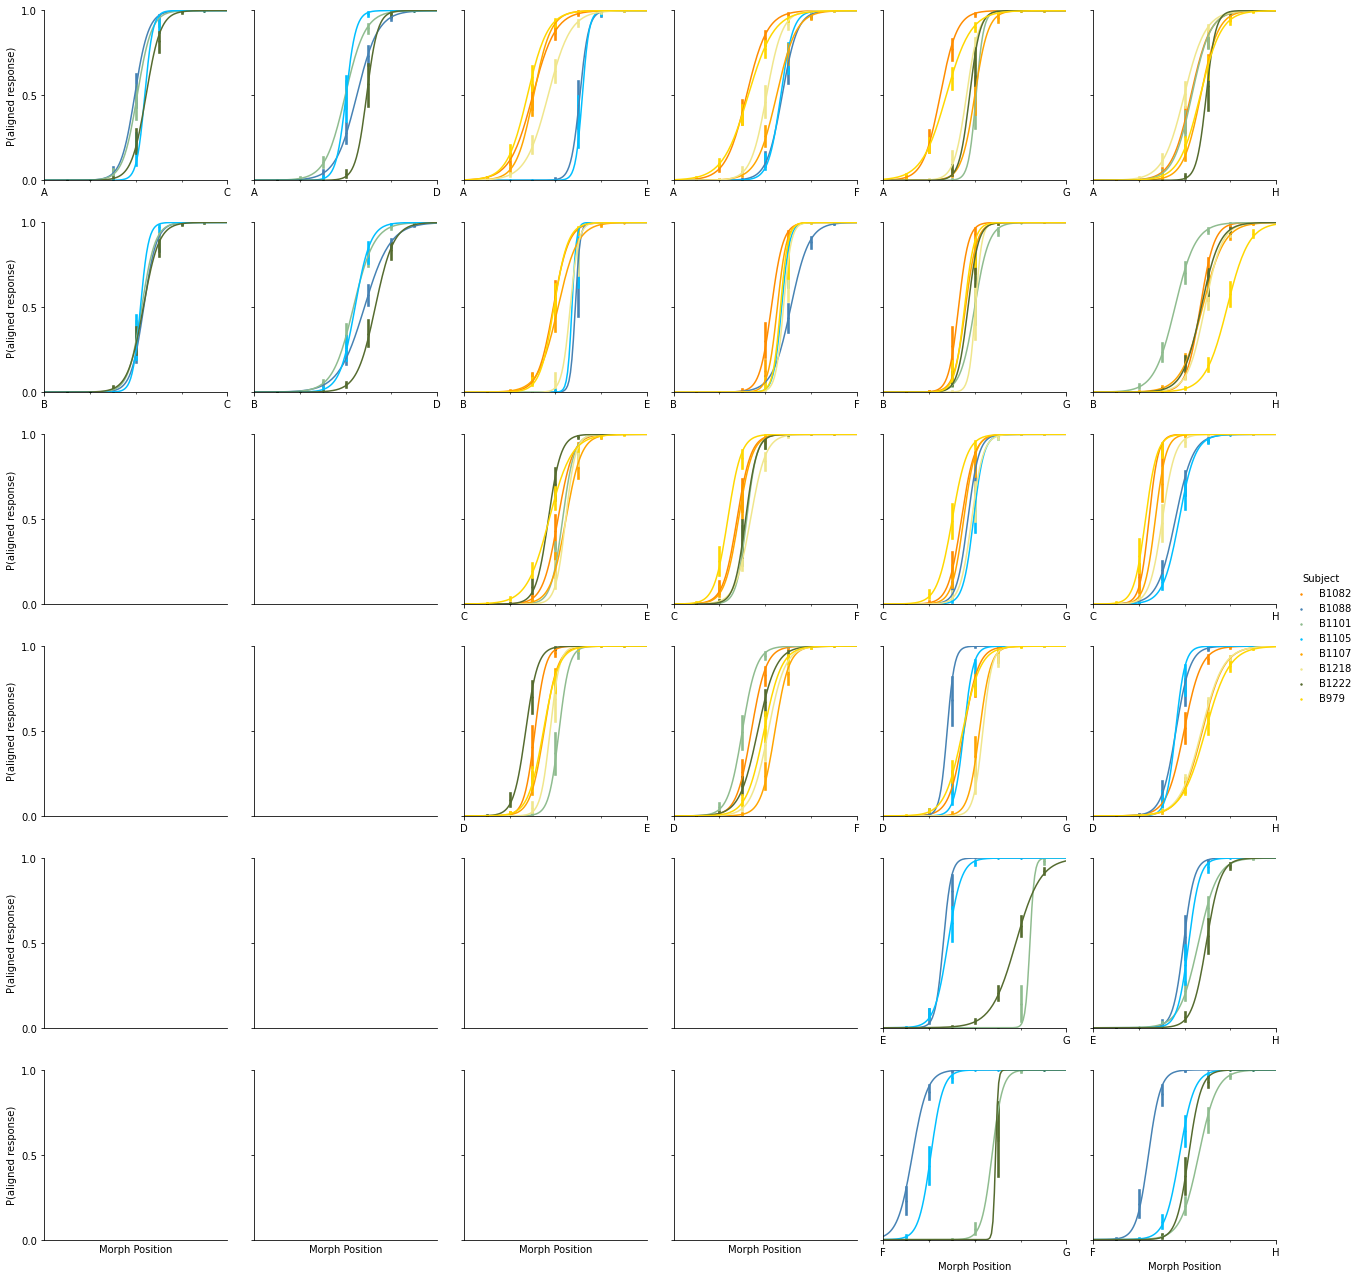

In [18]:
plot_psychometric(all_df[all_df.condition=='target'],
                  x='id',
                  y='value',
                  hue='subj',
                  scatter_kws={"s": 2},
                  x_bins=7,
                  col_order="cdefgh",
                  row_order="abcdef",
                  fit_reg='4pl',
                  custom_palette=subj_palette,)